# Vision Transformer (ViT) for Image Classification [5 points]
Use a Vision Transformer to solve the Cats and Dogs Dataset. You can use pre-defined ViT model or implement from scratch.
Deploy the model and record a short video (~5 mins) on how it works.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import os
import time
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

## Steps:

1. Load and preprocess the dataset. This may include resizing images, normalizing pixel values, and splitting the dataset into training, validation, and testing sets.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
!unzip /content/kagglecatsanddogs_5340 -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/PetImages/Dog/5500.jpg  
  inflating: data/PetImages/Dog/5501.jpg  
  inflating: data/PetImages/Dog/5502.jpg  
  inflating: data/PetImages/Dog/5503.jpg  
  inflating: data/PetImages/Dog/5504.jpg  
  inflating: data/PetImages/Dog/5505.jpg  
  inflating: data/PetImages/Dog/5506.jpg  
  inflating: data/PetImages/Dog/5507.jpg  
  inflating: data/PetImages/Dog/5508.jpg  
  inflating: data/PetImages/Dog/5509.jpg  
  inflating: data/PetImages/Dog/551.jpg  
  inflating: data/PetImages/Dog/5510.jpg  
  inflating: data/PetImages/Dog/5511.jpg  
  inflating: data/PetImages/Dog/5512.jpg  
  inflating: data/PetImages/Dog/5513.jpg  
  inflating: data/PetImages/Dog/5514.jpg  
  inflating: data/PetImages/Dog/5515.jpg  
  inflating: data/PetImages/Dog/5516.jpg  
  inflating: data/PetImages/Dog/5517.jpg  
  inflating: data/PetImages/Dog/5518.jpg  
  inflating: data/PetImages/Dog/5519.jpg  
  inflating: data/PetImages/Dog/552.jpg  
  inf

In [ ]:
DATASET_PATH = "/content/data/PetImages"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
class CustomDataset(ImageFolder):

    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (Image.DecompressionBombError, Image.UnidentifiedImageError, OSError) as e:
            print(f"Skipping corrupted image: {self.imgs[index][0]}")
            return self.__getitem__((index + 1) % len(self.imgs))

In [ ]:
dataset = CustomDataset(root=DATASET_PATH, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(f"Training samples: {train_size}, Validation samples: {val_size}, Test samples: {test_size}")

Training samples: 20000, Validation samples: 2500, Test samples: 2500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

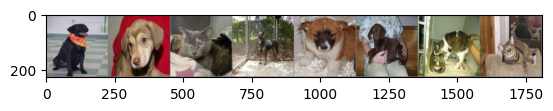

Labels: tensor([1, 1, 0, 1, 1, 1, 0, 0])


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(f"Labels: {labels[:8]}")

2. Choose to use a pre-defined ViT model or implement it from scratch. You can use an in-built predefined models for this part.

In [ ]:
model = vit_b_16(pretrained=True)
num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 108MB/s]


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, save_path="best_vit_model.pth"):
    model.train()
    best_val_acc = 0.0

    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f" Model saved at epoch {epoch+1} with Val Accuracy: {val_acc:.2f}%")

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%, Time: {time.time()-start_time:.2f}s")

    print(f"\n Training complete! Best validation accuracy: {best_val_acc:.2f}%")

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

3. Train and evaluate your ViT model. Discuss your results.

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Skipping corrupted image: /content/data/PetImages/Cat/666.jpg
Skipping corrupted image: /content/data/PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


 Model saved at epoch 1 with Val Accuracy: 96.28%
Epoch [1/5], Loss: 0.0749, Val Accuracy: 96.28%, Time: 688.33s
Skipping corrupted image: /content/data/PetImages/Cat/666.jpg
Skipping corrupted image: /content/data/PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


 Model saved at epoch 2 with Val Accuracy: 97.28%
Epoch [2/5], Loss: 0.0504, Val Accuracy: 97.28%, Time: 691.08s
Skipping corrupted image: /content/data/PetImages/Dog/11702.jpg
Skipping corrupted image: /content/data/PetImages/Cat/666.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [3/5], Loss: 0.0423, Val Accuracy: 96.84%, Time: 690.56s
Skipping corrupted image: /content/data/PetImages/Cat/666.jpg
Skipping corrupted image: /content/data/PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


 Model saved at epoch 4 with Val Accuracy: 97.32%
Epoch [4/5], Loss: 0.0377, Val Accuracy: 97.32%, Time: 691.81s
Skipping corrupted image: /content/data/PetImages/Dog/11702.jpg
Skipping corrupted image: /content/data/PetImages/Cat/666.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [5/5], Loss: 0.0354, Val Accuracy: 96.24%, Time: 691.47s

 Training complete! Best validation accuracy: 97.32%
Test Accuracy: 96.32%


Right from the very first epoch, our model delivers an impressive 96.28 % validation accuracy with a loss of 0.0749, showing it immediately grasps the key differences between cats and dogs. By epoch 2, accuracy climbs to 97.28 % and loss falls to 0.0504, reflecting rapid learning of the critical visual cues.

Over the next few epochs, training loss continues its steady decline—reaching 0.0354 by epoch 5—but validation accuracy tells a slightly different story: it peaks at 97.32 % in epoch 4 before gently receding to 96.24 % in epoch 5. That small dip, occurring alongside ever‑lower training loss, is a classic sign of the model beginning to overfit. In practice, the checkpoint saved at epoch 4 represents the optimal trade‑off between fitting and generalization and would be the one to deploy.

4. Deploy your trained ViT model. This could be a simple script or application that takes an image as input and predicts whether it's a cat or a dog.

In [ ]:
import streamlit as st
import torch
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

@st.cache(allow_output_mutation=True)
def load_the_model():
    model = vit_b_16(pretrained=True)
    number_features = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(number_features, 2)
    model.load_state_dict(torch.load("best_vit_model.pth", map_location=device))
    model = model.to(device)
    model.eval()
    return model

model = load_the_model()

st.title("Cat vs Dog Classifier")
st.write("Upload an image and the model will predict whether it is a cat or a dog.")

Uploaded_File = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if Uploaded_File is not None:
    try:
        image = Image.open(Uploaded_File).convert("RGB")
    except Exception as e:
        st.error("Error loading image!")

    st.image(image, caption="Uploaded Image", use_column_width=True)

    input_image = transformer(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = torch.max(outputs, 1)

    class_names = ["Cat", "Dog"]
    prediction = class_names[predicted.item()]

    st.write(f"### Prediction: {prediction}")


The above is a streamlit app that takes an image as input and predicts whether it is a dog or cat

5. Record a short video (~5 mins) demonstrating how your deployed ViT model works. The video should showcase the model taking image inputs and providing predictions. Explain the key aspects of your implementation and deployment process in the video.
   a. Upload the video to UBbox and create a shared link
   b. Add the link at the end of your ipynb file.

app link - https://huggingface.co/spaces/shishir1/Dog_and_Cat_Classifier <br>


**Shared UBbox Video Link:**

https://buffalo.box.com/s/6g8gxfzdudkrkv7qfzzy1o9x5ya1b35o

6. References. Include details on all the resources used to complete this part.

1) Dataset link - https://www.microsoft.com/en-us/download/details.aspx?id=54765 <br>
2) https://pytorch.org/vision/main/transforms.html <br>
3) https://www.kaggle.com/code/abdelrahmanmahmoud11/vit-b-16 <br>
4) https://streamlit.io/cloud